## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, recall_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

## Reading Data

In [2]:
# reading CSVs
vehicle_df = pd.read_csv('../data/localdata/Traffic_Crashes_Vehicles.csv')
people_df = pd.read_csv('../data/localdata/Traffic_Crashes_People.csv')
crash_df = pd.read_csv('../data/localdata/Traffic_Crashes_Crashes.csv')

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (20,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Cleaning

In [3]:
# Crashes DataFrame

crash_df.drop(columns=['WORK_ZONE_I', 'WORK_ZONE_TYPE', 'DOORING_I', 'WORKERS_PRESENT_I',
                                          'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'RD_NO', 'REPORT_TYPE', 'CRASH_DATE_EST_I'], axis=1, inplace=True)
crash_df.dropna(subset = ['INJURIES_TOTAL', 'LATITUDE', 'MOST_SEVERE_INJURY', 
                          'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE'], axis=0, inplace=True)
crash_df.columns = crash_df.columns.str.title()
crash_df.columns = crash_df.columns.str.replace('_', ' ')

In [4]:
# Vehicles DataFrame

vehicle_df = vehicle_df[['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO', 'UNIT_TYPE',
                       'VEHICLE_YEAR', 'VEHICLE_USE', 'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'MANEUVER', 'OCCUPANT_CNT',
                         'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I',
                       'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I',
                       'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT']]
vehicle_df.dropna(subset = ['VEHICLE_USE', 'FIRST_CONTACT_POINT', 'UNIT_TYPE'], axis=0, inplace=True)
vehicle_df['VEHICLE_YEAR'].fillna(value = 'Unknown', inplace=True)

vehicle_df.columns = vehicle_df.columns.str.title()
vehicle_df.columns = vehicle_df.columns.str.replace('_', ' ')

In [5]:
# People DataFrame

people_df.drop(columns=['RD_NO', 'CELL_PHONE_USE', 'PEDPEDAL_ACTION', 
                        'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'SEAT_NO', 
                        'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'BAC_RESULT', 'BAC_RESULT VALUE', 
                        'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'CITY', 'STATE', 'ZIPCODE']
               , axis=1, inplace=True)

people_df.dropna(subset = ['AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'VEHICLE_ID', 
                           'SAFETY_EQUIPMENT', 'SEX'], axis=0, inplace=True)

people_df.columns = people_df.columns.str.title()
people_df.columns = people_df.columns.str.replace('_', ' ')

## Feature Engineering Crash Score

In [6]:
# Injury Score

crash_df[['Injuries Total', 'Injuries Fatal', 'Injuries Incapacitating', 
            'Injuries Non Incapacitating', 'Injuries Reported Not Evident']][crash_df['Injuries Total']!=0][:50]

crash_df['total injured'] = crash_df['Injuries Fatal'] + crash_df['Injuries Incapacitating'] + crash_df['Injuries Non Incapacitating'] + crash_df['Injuries Reported Not Evident']

# Checking if added up columns in 'total injured' make up 'Injuries Total'
(crash_df['total injured'] == crash_df['Injuries Total']).value_counts()

# Injury Score column is a linear combination of the factors that make up Injuries Total simply multiplied by a constant depending on their severity
crash_df['Injury Score'] = crash_df['Injuries Fatal']*7 + crash_df['Injuries Incapacitating']*3 + crash_df['Injuries Non Incapacitating']*2 + crash_df['Injuries Reported Not Evident']

# Accounting Material Damage of Car and Surrounding Areas )
# Crash Score 

crash_df['Damage'].value_counts()
mapping = {'OVER $1,500': 3, '$501 - $1,500': 2, "$500 OR LESS": 1}
crash_df['Damage_ODE'] = crash_df['Damage'].map(mapping)
crash_df['Injury Score'] = crash_df['Injury Score'] + crash_df['Damage_ODE']*3
crash_df['Crash Score'] = crash_df['Injury Score']

## Injury Classification Column (Predictor)

In [7]:
# def fill_injury_class_rows(row):
#     if row["Injuries Fatal"] > 0 :
#         return 'Fatal'
#     elif row["Injuries Incapacitating"] > 0 :
#         return 'Incapacitating'
#     elif row['Injuries Non Incapacitating'] + row['Injuries Reported Not Evident'] > 0:
#         return 'Minor'
#     else:
#         return 'None Injured'

# crash_df['Injury Classification'] = crash_df.apply(fill_injury_class_rows, axis=1)

# crash_df['Injury Classification']

In [8]:
def fill_fatal_class_rows(row):
    if row["Injuries Fatal"] > 0 :
        return 'Fatal'
    else:
        return 'Not Fatal'

crash_df['Fatality Classification'] = crash_df.apply(fill_fatal_class_rows, axis=1)

In [9]:
crash_df['Fatality Classification'].value_counts(normalize=True)


Not Fatal    0.998912
Fatal        0.001088
Name: Fatality Classification, dtype: float64

In [10]:
crash_df['First Crash Type'].value_counts()

PARKED MOTOR VEHICLE            174074
REAR END                        168995
SIDESWIPE SAME DIRECTION        113131
TURNING                         106334
ANGLE                            81051
FIXED OBJECT                     34650
PEDESTRIAN                       17163
PEDALCYCLIST                     11205
SIDESWIPE OPPOSITE DIRECTION     10627
OTHER OBJECT                      7184
REAR TO FRONT                     6780
HEAD ON                           6386
REAR TO SIDE                      4036
OTHER NONCOLLISION                2287
REAR TO REAR                      1435
ANIMAL                             529
OVERTURNED                         446
TRAIN                               39
Name: First Crash Type, dtype: int64

In [11]:
crash_df['Prim Contributory Cause'].value_counts()

UNABLE TO DETERMINE                                                                 288602
FAILING TO YIELD RIGHT-OF-WAY                                                        81766
FOLLOWING TOO CLOSELY                                                                73678
NOT APPLICABLE                                                                       39190
IMPROPER OVERTAKING/PASSING                                                          36649
FAILING TO REDUCE SPEED TO AVOID CRASH                                               31683
IMPROPER BACKING                                                                     29952
IMPROPER LANE USAGE                                                                  26990
IMPROPER TURNING/NO SIGNAL                                                           24770
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  24671
DISREGARDING TRAFFIC SIGNALS                                                         14523

## Merging Vehicle and Crash DataFrames

In [12]:
vehicles_crashes_df = vehicle_df.merge(crash_df, on = 'Crash Record Id', how = 'inner')
vehicles_crashes_df.drop_duplicates(subset='Crash Record Id', inplace=True)

In [13]:
categorical = ['Weather Condition', 'Roadway Surface Cond', 'Road Defect', 'Alignment',
                       'Traffic Control Device', 'Device Condition', 'Crash Hour', 'Trafficway Type', 'Maneuver', 'Vehicle Defect',
               'Lighting Condition', 'First Crash Type', 'Prim Contributory Cause', 'Sec Contributory Cause'] #potentiall vehicle defects

ohe = OneHotEncoder(drop='first')
ohe.fit(vehicles_crashes_df[categorical])

categorical_encoded = pd.DataFrame(ohe.transform(vehicles_crashes_df[categorical]).todense(),
                               columns=ohe.get_feature_names())
# for Nick's version of OneHotEncoder, since its newer, the attribute is get_feature_names_out but get_feature_name for bobby and mike's version

In [14]:
categorical_encoded.shape

(745092, 238)

In [15]:
vehicles_crashes_df.shape

(745092, 70)

## Creating Train_Test_Split

In [16]:
#X = categorical_encoded
#y = vehicles_crashes_df['Fatal Classification']

#X_train, X_test, y_train, y_test = train_test_split(X, y)

## Creating Dummy Model

In [17]:
#Instantiate dummy model that will always predict majority class
#dummy_model = DummyClassifier(strategy="most_frequent", random_state = 42)
#dummy_model.fit(X_train, y_train)

#baseline score
#dummy_model.score(X_train, y_train)

In [18]:
#y_train.value_counts(normalize=True)

In [19]:
#can also grab cross_val mean to see how it’s performing
#cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
#cv_results.mean()

## Testing Dummy Model

In [20]:
#dummy_model.score(X_test, y_test)

## Creating Logistic Regression Model

In [21]:
# logreg = LogisticRegression(random_state=42, max_iter = 1000)
# log_model = logreg.fit(X_train, y_train)

# y_hat_train = log_model.predict(X_train)
# y_hat_test = log_model.predict(X_test)

In [22]:
#plot_confusion_matrix(log_model, X_train, y_train);

In [23]:
# print("Training Score: ", log_model.score(X_train, y_train))
# print("Testing Score: ", log_model.score(X_test, y_test))

## SMOTE

In [24]:
#CAUTION! This code takes about 20 minutes to run.
# # Instantiate our SMOTE
# sm = SMOTE(random_state=42)
# # Fit and resample on the training data
# X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [25]:
#CAUTION! This code takes about 2 hours to run. 

# #Run Log Model on resampled SMOTE data
# log_model = logreg.fit(X_train_smote, y_train_smote)

# print("Training Score: ", log_model.score(X_train_smote, y_train_smote))
# print("Testing Score: ", log_model.score(X_test, y_test))

In [26]:
#y_train_smote.value_counts()

In [27]:
#plot_confusion_matrix(log_model, X_train_smote, y_train_smote);

Looking at this confusion matrix, it appeared that the model was performing well when predicting Fatal and None Injured. As Vision Zero's goal is for zero fatalities, we decided to hone our focus on Fatal vs. Not Fatal.

## Decision Tree Model

In [28]:
# normal decision tree model
# clf = DecisionTreeClassifier(criterion='gini', random_state=42, )

# clf.fit(X_train, y_train)

# y_preds = clf.predict(X_test)

# print('Accuracy: ', accuracy_score(y_test, y_preds))

# smote decision tree model
# clf = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth =10)

# clf.fit(X_train_smote, y_train_smote)

# y_preds = clf.predict(X_test)

# print('Accuracy: ', accuracy_score(y_test, y_preds))

## Creating Train_Test_Split for Fatal vs. Not Fatal

In [29]:
vehicles_crashes_df['Fatality Classification'].value_counts(normalize=True)

Not Fatal    0.998914
Fatal        0.001086
Name: Fatality Classification, dtype: float64

In [30]:
X = categorical_encoded
y = vehicles_crashes_df['Fatality Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
#Instantiate dummy model that will always predict majority class
dummy_model = DummyClassifier(strategy="most_frequent", random_state = 42)
dummy_model.fit(X_train, y_train)

y_true = y_train
y_pred = dummy_model.predict(X_train)
#baseline score
recall_score(y_true, y_pred, pos_label='Fatal')

0.0

In [32]:
recall_scorer = make_scorer(recall_score, pos_label='Fatal')

In [33]:
cv_dummy = cross_val_score(estimator = dummy_model, X=X_train, y=y_train, scoring = recall_scorer, n_jobs=-1).mean()
cv_dummy

0.0

## Logreg

In [63]:
logreg = LogisticRegression(random_state=42, max_iter = 1000, class_weight = 'balanced')
log_model = logreg.fit(X_train, y_train)
y_true = y_train
y_pred = log_model.predict(X_train)
recall_score(y_true, y_pred, pos_label = 'Fatal')

KeyboardInterrupt: 

In [70]:
logreg = LogisticRegression(random_state=42, max_iter = 2000, class_weight = 'balanced', penalty = 'none')
log_model = logreg.fit(X_train, y_train)
y_true = y_train
y_pred = log_model.predict(X_train)
recall_score(y_true, y_pred, pos_label = 'Fatal')

0.8611570247933884

In [35]:
# Attempting to flip our confusion matrix so Fatal is positive label
#cm = confusion_matrix(y_true, y_pred).T
#cm

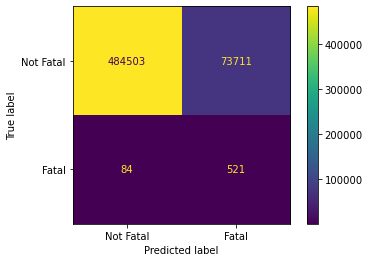

In [69]:
plot_confusion_matrix(log_model, X_train, y_train, labels = ['Not Fatal', 'Fatal']);

In [65]:
y_train

499369     Not Fatal
846628     Not Fatal
10629      Not Fatal
1366422    Not Fatal
758938     Not Fatal
             ...    
520787     Not Fatal
731738     Not Fatal
268601     Not Fatal
1337915    Not Fatal
248902     Not Fatal
Name: Fatality Classification, Length: 558819, dtype: object

0.8611570247933884

In [66]:
log_model.classes_

array(['Fatal', 'Not Fatal'], dtype=object)

In [37]:
cv_scores = cross_val_score(estimator = log_model, X=X_train, y=y_train, scoring = recall_scorer, n_jobs=4).mean()
cv_scores

0.7586776859504132

In [38]:
sm = SMOTE(random_state=42, sampling_strategy = 0.1)

X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)



In [71]:
log_model_smote = logreg.fit(X_train_smote, y_train_smote)

y_true_smote = y_train_smote
y_pred_smote = log_model_smote.predict(X_train_smote)

print("Training recall: ", recall_score(y_true_smote, y_pred_smote, pos_label = 'Fatal'))

Training recall:  0.8963651672309704


In [72]:
cv_scores_smote = cross_val_score(estimator = log_model_smote, X=X_train_smote, y=y_train_smote, 
                                  scoring = recall_scorer, n_jobs = -1).mean()
cv_scores_smote

0.8957560648126384

In [41]:
log_model_smote.coef_

array([[ 3.08236849e+00, -9.34795466e-01, -9.58358904e-01,
         1.44052883e-01,  1.72622808e-01,  4.17152147e-01,
        -9.55200762e-01, -2.70584340e+00,  3.67563794e+00,
        -5.15731249e-01, -4.23017804e-01,  1.10597901e+00,
        -5.33343437e-01,  3.75411988e+00,  8.21392907e-01,
         4.81154803e-01,  4.68515048e-01, -1.63942300e+00,
        -8.58340265e-01,  2.15341212e+00, -1.25815250e+00,
        -1.35920833e+00, -2.46281048e+00,  6.34287678e-01,
         4.38251667e-03,  2.83466932e-01,  2.08013012e-01,
         5.00867905e-01,  2.21818535e+00,  3.29088355e+00,
         4.09143085e+00, -2.69031001e+00,  9.49426107e-01,
        -2.21913314e+00,  2.17389534e+00,  3.75300482e+00,
         1.47384009e-01, -1.18363082e+00, -3.44188412e+00,
        -2.35792624e+00,  1.95137340e+00, -2.17511363e+00,
        -1.42583501e+00, -1.86796638e+00, -2.81333254e+00,
         6.89082016e-01, -1.15679480e+00,  1.24511298e+00,
        -4.96568680e-01,  9.69979269e-01, -1.11929489e-0

## Decision Tree Model

In [61]:
#normal decision tree model
clf = DecisionTreeClassifier(criterion='gini', random_state=42, class_weight = 'balanced', max_depth = 24, min_samples_split = 5000)

clf.fit(X_train, y_train)

y_preds = clf.predict(X_train)

print('Recall: ', recall_score(y_train, y_preds, pos_label = 'Fatal'))

#smote decision tree model


Recall:  0.9355371900826446


In [62]:
cv_score_tree = cross_val_score(estimator = clf, X=X_train, y=y_train, scoring = recall_scorer, n_jobs=-1).mean()
cv_score_tree

0.7388429752066116

In [103]:
clf_smote = DecisionTreeClassifier(criterion='gini', random_state=42, class_weight = 'balanced', max_depth = 24,
                                   min_samples_split = 2500)

clf_smote.fit(X_train_smote, y_train_smote)

y_preds_smote = clf_smote.predict(X_train_smote)

print('Recall: ', recall_score(y_train_smote, y_preds_smote, pos_label = 'Fatal'))

Recall:  0.9776249081886745


In [104]:
cv_smote_tree = cross_val_score(estimator = clf_smote, X=X_train_smote, y=y_train_smote, scoring = recall_scorer,
                                n_jobs=-1).mean()
cv_smote_tree

0.9675569977903834

In [76]:
feature_importance = clf_smote.feature_importances_
feature_importance

array([0.00000000e+00, 3.10468777e-03, 7.11017903e-04, 0.00000000e+00,
       1.24962741e-05, 0.00000000e+00, 1.16502924e-06, 0.00000000e+00,
       0.00000000e+00, 2.98886418e-03, 2.69496656e-03, 0.00000000e+00,
       1.48161935e-03, 0.00000000e+00, 0.00000000e+00, 3.05474419e-04,
       0.00000000e+00, 0.00000000e+00, 1.98554493e-03, 6.94729618e-04,
       0.00000000e+00, 9.05354781e-04, 2.92513391e-03, 1.75873014e-05,
       5.14184255e-04, 7.53959453e-04, 4.67206374e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.04136041e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.16943870e-03, 2.23805531e-03,
       1.25170649e-06, 0.00000000e+00, 4.96447264e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.97360147e-04, 5.84860824e-06, 7.34670975e-04,
      

In [78]:
categorical_encoded.columns

Index(['x0_BLOWING SNOW', 'x0_CLEAR', 'x0_CLOUDY/OVERCAST',
       'x0_FOG/SMOKE/HAZE', 'x0_FREEZING RAIN/DRIZZLE', 'x0_OTHER', 'x0_RAIN',
       'x0_SEVERE CROSS WIND GATE', 'x0_SLEET/HAIL', 'x0_SNOW',
       ...
       'x13_PHYSICAL CONDITION OF DRIVER', 'x13_RELATED TO BUS STOP',
       'x13_ROAD CONSTRUCTION/MAINTENANCE',
       'x13_ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 'x13_TEXTING',
       'x13_TURNING RIGHT ON RED', 'x13_UNABLE TO DETERMINE',
       'x13_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'x13_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'x13_WEATHER'],
      dtype='object', length=238)

In [83]:
feature_importances = pd.Series(list(feature_importance), name = 'feature_importance')
features = pd.Series(list(categorical_encoded), name = 'features')


In [85]:
features

0                                        x0_BLOWING SNOW
1                                               x0_CLEAR
2                                     x0_CLOUDY/OVERCAST
3                                      x0_FOG/SMOKE/HAZE
4                               x0_FREEZING RAIN/DRIZZLE
                             ...                        
233                             x13_TURNING RIGHT ON RED
234                              x13_UNABLE TO DETERMINE
235    x13_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE ...
236    x13_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDI...
237                                          x13_WEATHER
Name: features, Length: 238, dtype: object

In [86]:
feature_importances

0      0.000000
1      0.003105
2      0.000711
3      0.000000
4      0.000012
         ...   
233    0.000000
234    0.004039
235    0.000850
236    0.000517
237    0.000000
Name: feature_importance, Length: 238, dtype: float64

In [94]:
features_df = pd.DataFrame([feature_importances, features]).transpose()

In [95]:
features_df

,feature_importance,features
0,0,x0_BLOWING SNOW
1,0.00310469,x0_CLEAR
2,0.000711018,x0_CLOUDY/OVERCAST
3,0,x0_FOG/SMOKE/HAZE
4,1.24963e-05,x0_FREEZING RAIN/DRIZZLE
...,...,...
233,0,x13_TURNING RIGHT ON RED
234,0.00403949,x13_UNABLE TO DETERMINE
235,0.000850417,x13_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE ...
236,0.000517494,"x13_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDI..."


In [97]:
features_df.sort_values(by='feature_importance', inplace=True, ascending=False)

In [107]:
features_df.head(15)

,feature_importance,features
144,0.241439,x11_FIXED OBJECT
151,0.205578,x11_PEDESTRIAN
138,0.120508,"x10_DARKNESS, LIGHTED ROAD"
165,0.0582626,x12_DISREGARDING TRAFFIC SIGNALS
189,0.0572081,x12_PHYSICAL CONDITION OF DRIVER
150,0.0368247,x11_PEDALCYCLIST
145,0.0334712,x11_HEAD ON
185,0.0162393,x12_NOT APPLICABLE
117,0.0145614,x8_TURNING LEFT
177,0.0139773,x12_FAILING TO YIELD RIGHT-OF-WAY


## Testing data

In [105]:
y_preds_test = clf_smote.predict(X_test)
print('Recall: ', recall_score(y_test, y_preds_test, pos_label = 'Fatal'))

Recall:  0.43137254901960786


In [108]:
y_pred_test = log_model_smote.predict(X_test)

print("Training recall: ", recall_score(y_test, y_pred_test, pos_label = 'Fatal'))

Training recall:  0.7107843137254902
